# Preparing the corpus

In [1]:
# hide jupyter warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [3]:
import pyLDAvis
import pyLDAvis.gensim

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

/anaconda/envs/pfe-env/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [4]:
df = pd.read_json('../input/iphone-12-tweets-fr.json', lines=True)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# remove duplicates 
# 840 tweets had been droped

df = df[df['lang'] == 'fr']
df = df.sort_values("content") 
  
# dropping ALL duplicte values 
df = df.drop_duplicates(subset ="content", keep = 'first')

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# selectionner que les tweets qui répondent au requetes de l'utilisateur

data = df['content']

with open('../input/keywords.txt', encoding='utf-8') as f:
    keywords = f.read().splitlines()

data = data[data.str.contains('|'.join(keywords), case=False)]

# supprimer les tweets inutiles (publicité, concours ..)

with open('../input/ads_words.txt', encoding='utf-8') as f:
    ads_words = f.read().splitlines()

data = data[~data.str.contains('|'.join(ads_words), case=False)]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
import re
import json
from html.parser import HTMLParser
from io import StringIO

import demoji
demoji.download_codes()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


... OK (Got response in 0.39 seconds)
Writing emoji data to /home/azureuser/.demoji/codes.json ...
... OK


In [8]:
class MLStripper(HTMLParser):
        def __init__(self):
            super().__init__()
            self.reset()
            self.strict = False
            self.convert_charrefs= True
            self.text = StringIO()
        def handle_data(self, d):
            self.text.write(d)
        def get_data(self):
            return self.text.getvalue()
        
def html_free_text(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def emoji_free_text(text):
    return demoji.replace(text, '').strip()

def url_free_text(text):
    text = re.sub(r'(?:\@|https?\://)\S+', '', text)
    return text
    
with open('../input/abrivot_fr.json', encoding='utf-8') as f:
        abrivot = json.load(f)   
        
def abrivot_free_text(text):
    words = text.lower().split()
    text_out = [abrivot[word] if word in abrivot else word for word in words]
    return ' '.join(text_out)

def punct_free_text(text):
    text_out = simple_preprocess(text, deacc=True, min_len=3)
    #return ' '.join(text_out)
    return text_out

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Pre-Process the data

In [9]:
%%time

data_free_html = data.apply(html_free_text)
data_free_emoji = data_free_html.apply(emoji_free_text)
data_free_url = data_free_emoji.apply(url_free_text)
data_free_abrivot = data_free_url.apply(abrivot_free_text)
data_free_punct = data_free_url.apply(punct_free_text)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 12.1 s, sys: 5.33 ms, total: 12.1 s
Wall time: 12.1 s


In [10]:
# Build the bigram and trigrams

data = list(data_free_punct)

bigram = gensim.models.Phrases(data, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# define a preprocessing function

# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])

# get stopwords
# ask the user to specify the brand name to be added to the stopwords
# or implement it manually
with open('../input/fr_stopwords.txt', encoding='utf-8') as f:
    fr_stopwords = f.read().splitlines()
stop_words = nlp.Defaults.stop_words.union(fr_stopwords)


# final preprocesser
def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    #texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    texts = [[word for word in doc if word not in stop_words] for doc in texts]

    
    # bi-gram and tri-gram implementation
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
%%time

data_ready = process_words(data)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 48.4 s, sys: 27.2 ms, total: 48.4 s
Wall time: 48.4 s


In [18]:
# create the Dictionary

id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Vocabulary Size: 5196


In [19]:
# create the corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
dict_corpus = {}

for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if id2word[idx] in dict_corpus:
            dict_corpus[id2word[idx]] += freq
        else:
            dict_corpus[id2word[idx]] = freq

dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


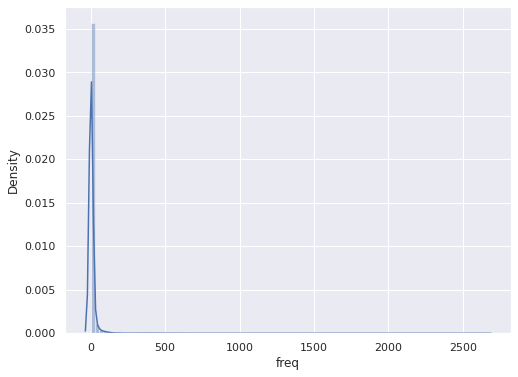

In [21]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [22]:
dict_df.sort_values('freq', ascending=False).head(10)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,freq
max,2654
iphone,1652
pro,1622
prix,1562
apple,1347
photo,1234
batterie,1062
mini,925
chargeur,535
euro,432


In [23]:
threshold = 1600
extension = dict_df[dict_df.freq>threshold].index.tolist()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# ask the user to specify the brand name to be added to the stopwords
# or implement it manually

extension.append('apple')
extension.append('appl')

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# add high frequency words to stop words list
stop_words.update(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Vocabulary Size: 4969


In [26]:
# Filter extreme words
# Filter out words that occur less than 10 documents, or more than
# 90% of the documents.

#id2word.filter_extremes(no_below=10, no_above=0.7)
id2word.filter_extremes(no_below=10, no_above=0.8)
print('Total Vocabulary Size:', len(id2word))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Vocabulary Size: 654


In [27]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Finding the optimal number of topics

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaMulticore, CoherenceModel
from gensim import corpora

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
%%time

# Considering 10-70 topics, as the last is cut off
num_topics = list(range(5, 50, 2)[1:])
num_keywords = 10

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaMulticore(corpus=corpus,
                                id2word=id2word,
                                num_topics=i,
                                chunksize=2000,
                                passes=25,
                                iterations=70,
                                decay=0.5,
                                random_state=100)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 7min 54s, sys: 27.9 s, total: 8min 22s
Wall time: 8min 9s


In [30]:
# Now create a function to derive the Jaccard similarity of two topics:

def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# Use the above to derive the mean stability across topics by considering the next topic:

LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# calculate the coherence value with the built in gensim

coherences = [CoherenceModel(model=LDA_models[i], texts=data_ready, dictionary=id2word, coherence='c_v').get_coherence() for i in num_topics[:-1]]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# From here derive the ideal number of topics roughly through the difference between the coherence and stability per number of topics:

coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


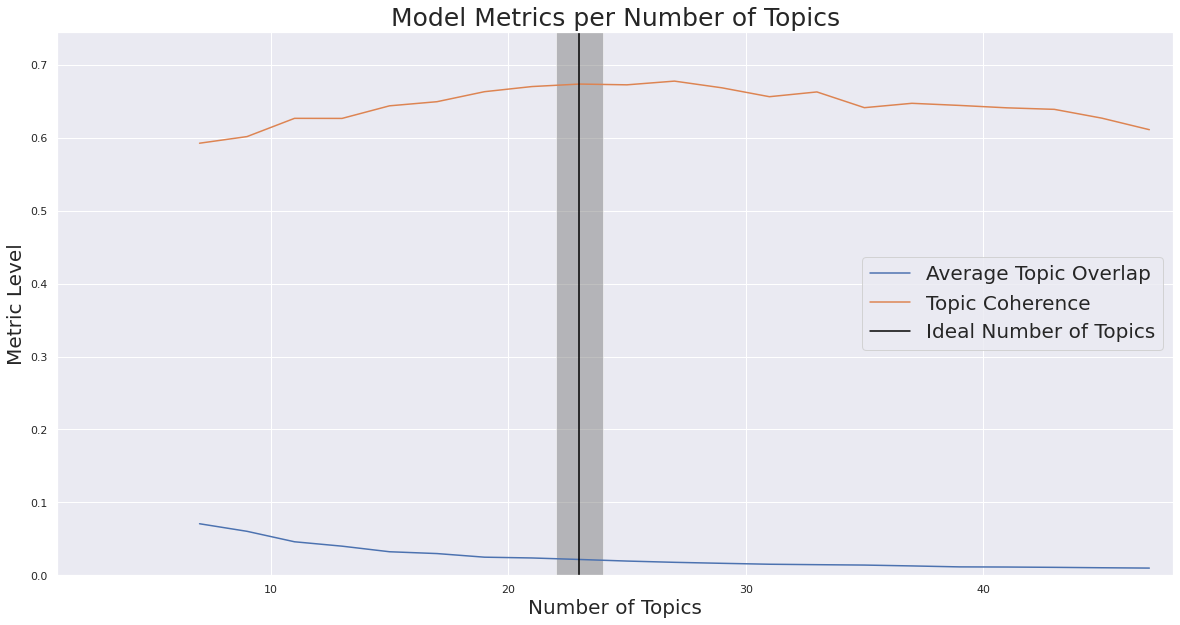

In [34]:
# Finally graph these metrics across the topic numbers:

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

Your ideal number of topics will maximize coherence and minimize the topic overlap based on Jaccard similarity.

In [36]:
print('Ideal number of topics: ', ideal_topic_num)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ideal number of topics:  23


# Building the LDA Model

Download the LDA mallet from `!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip`  
Extract the model `!unzip mallet-2.0.8.zip`

In [37]:
# mallet_path = '../packages/mallet-2.0.8/bin/mallet'
# ldamallet = gensim.models.wrappers.LdaMallet(
#     mallet_path,
#     corpus=corpus,
#     num_topics=ideal_topic_num,
#     id2word=id2word,
#     alpha=.1)
# #(mallet_path, corpus=corpus, num_topics=28, id2word=id2word, topic_threshold=0.5)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
ldamallet = LDA_models[ideal_topic_num]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.6737773019727767


In [40]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(17,
  [('homepod', 0.13950762),
   ('annonce', 0.1334498),
   ('coup', 0.085596725),
   ('cadeau', 0.057615105),
   ('plaisir', 0.04698374),
   ('stockage', 0.032347977),
   ('qualite', 0.030932322),
   ('resume', 0.030271472),
   ('propos', 0.029415224),
   ('plan', 0.027902951)]),
 (7,
  [('studio', 0.18704833),
   ('smartphone', 0.1570104),
   ('ecoute_cherie', 0.13753542),
   ('difference', 0.09708842),
   ('magsafe', 0.08921076),
   ('albums_dedicace', 0.08713618),
   ('cuir', 0.051950008),
   ('dommage', 0.03377473),
   ('chance', 0.028544378),
   ('client', 0.027860083)]),
 (11,
  [('chargeur', 0.37051532),
   ('charge', 0.13590978),
   ('mini', 0.10433045),
   ('ecran', 0.07457141),
   ('ami', 0.055605877),
   ('plutot', 0.051487893),
   ('question', 0.05040415),
   ('conference', 0.0196647),
   ('operateur', 0.015378172),
   ('compact', 0.012957778)]),
 (13,
  [('semaine', 0.14749113),
   ('suite', 0.13039531),
   ('vente', 0.05548055),
   ('comparaison', 0.054675087),
   ('

In [41]:
# save the model for later

import pickle
pickle.dump(ldamallet, open("../saved models/ldamodel.pkl", "wb"))

# load the model
#ldamallet = pickle.load(open("../saved models/ldamallet.pkl", "rb"))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# distribution of topics for each document

tm_results = ldamallet[corpus]

# We can get the most dominant topic of each document as below:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# get most probable words for the given topicis

topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# create a dataframe for term-topic matrix:

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics],
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23
Term1,coque,jour,euro,autonomie,couleur,video,utilisation,studio,telephone,photo,...,semaine,keynote,offre,youtube,homepod,mois,prix,taille,igeneration,choisir
Term2,protection,super,sortie,fil,prefere,fonce,compte,smartphone,lieu,partie,...,suite,novembre,bilan,chaine,annonce,albums_dedicace,deballage,test_bluetooth,promo,pouce
Term3,appareil,accessoire,plan,acce,reparation,one,recu,ecoute_cherie,gamme,information,...,vente,reseau,point,argent,coup,ecoute_cherie,apprecie,samsung,cas,janvier
Term4,objectif,niveau,precommande,livre,equipe,base,heure,difference,date_sortie,dispo,...,comparaison,octobre,envie,besoin,cadeau,version,lien,part,fin,impression
Term5,devoile,vena,fonction,test,probleme,livraison,avis,magsafe,gnt,predecesseur,...,voi,capteur,whatsapp,vien,plaisir,place,fcfa,officiel,mode,vie


In [45]:
# another option

# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Terms per Topic
Topic1,"coque, protection, appareil, objectif, devoile, test, marche, prise, coque_etui, film, exceptionnelle, spigen, mini, cause, terme, concurrence, resultat, doigt, fle, preference"
Topic2,"jour, super, accessoire, niveau, vena, mini, choix, boite, poche, tech, connexion, espere, grace, bord, eau, store, profondeur, constructeur, photophone, fdp"
Topic3,"euro, sortie, plan, precommande, fonction, bonplan, venez, completement, fonds, etui, free, maison, solde, promotion, coute, souci, tranche, tenter_chance, mise_jour, ere"
Topic4,"autonomie, fil, acce, livre, test, minute, article, promotion, nom, mort, notification, commande, sony, definition, resolution, debit, dimanche, foxconn, evolution, fournisseur"
Topic5,"couleur, prefere, reparation, equipe, probleme, gauche, monsieur, service, commander, remise, perso, million, message, vitesse, jeu, famille, moche, photographie, propose, lot"
Topic6,"video, fonce, one, base, livraison, achete, cherche, casse, clavier, garantie, paie, possession, xiaomi, ville, date, usb, sondage, economie, nuit, profite"
Topic7,"utilisation, compte, recu, heure, avis, temps, recharge, covid, chaud, cote, technologie, face, production, peine, produit, mise, penurie, capte, source, veut"
Topic8,"studio, smartphone, ecoute_cherie, difference, magsafe, albums_dedicace, cuir, dommage, chance, client, silicone, verre, actualite, monde, retard, bug, train, macbook, concours, bande"
Topic9,"telephone, lieu, gamme, date_sortie, gnt, comprend, vendredi, piece, absence, rumeur, partage, prevu, sac, graphite, explose, faite, esim, vacance, tablette, americain"
Topic10,"photo, partie, information, dispo, predecesseur, meilleur, defaut, dolby_vision, huawei, ecologie, argument, arrete, luminosite, deh, finition, verrouillage, jure, immense, smart, retouche"


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


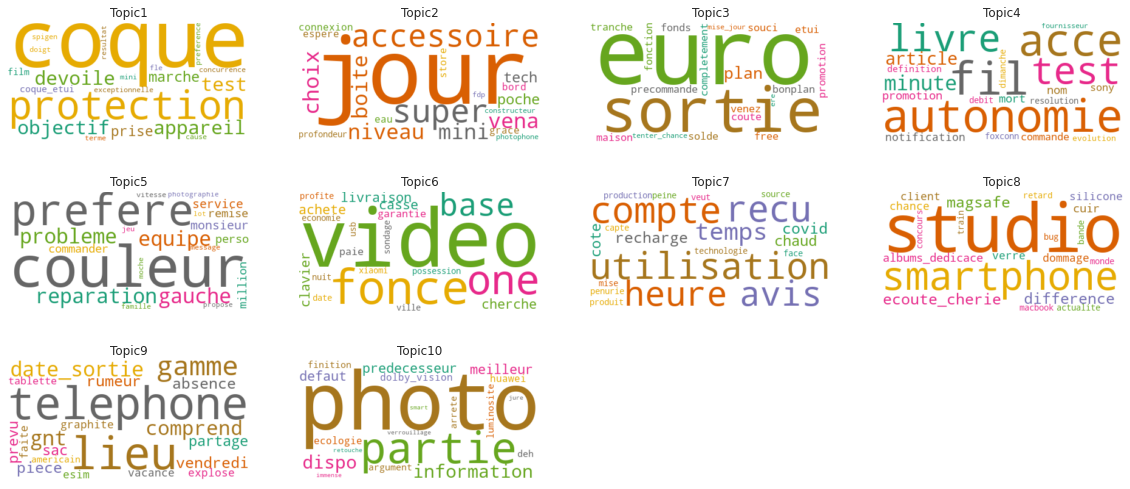

In [46]:
# worldcloud

# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [47]:
# visiualize with pyLDAvis
# the mallet model must be converted to a gensim lda model

# from gensim.models.ldamodel import LdaModel

# def convertldaMalletToldaGen(mallet_model):
#     model_gensim = LdaModel(
#         id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
#         alpha=mallet_model.alpha) 
#     model_gensim.state.sstats[...] = mallet_model.wordtopics
#     model_gensim.sync_state()
#     return model_gensim

# ldagensim = convertldaMalletToldaGen(ldamallet)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# import pyLDAvis.gensim as gensimvis

# vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
# pyLDAvis.display(vis_data)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamallet, corpus, id2word)
vis

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19     0.039880 -0.065111  1       1        5.583182
11    -0.079195  0.017306  2       1        5.438737
12     0.034403 -0.062422  3       1        5.344673
0     -0.265167  0.184629  4       1        5.109934
20     0.034831 -0.072211  5       1        5.011502
6     -0.019684 -0.034098  6       1        4.926853
9      0.036785 -0.075363  7       1        4.911610
17     0.050019 -0.083828  8       1        4.737151
7      0.253915  0.285449  9       1        4.337741
4      0.033736 -0.067951  10      1        4.291539
2      0.034233 -0.088150  11      1        4.215441
13     0.028583 -0.078853  12      1        4.169184
14    -0.139796  0.046413  13      1        4.167856
10    -0.279031  0.188248  14      1        4.022621
3     -0.014302 -0.037952  15      1        4.010384
22     0.033383 -0.063973  16      1        3.954623
16     0.011726 -0.055566  17      1        3.947236
1     -0.123898  0.033300  18      1        3.861822
8      0.020370 -0.066115  19      1        3.830217
21     0.032450 -0.068486  20      1        3.718122
15    -0.007647 -0.035164  21      1        3.685313
18     0.251150  0.279970  22      1        3.623868
5      0.033258 -0.080074  23      1        3.100394, topic_info=               Term         Freq        Total Category  logprob  loglift
24   photo           1096.000000  1096.000000  Default  30.0000  30.0000
9    batterie        880.000000   880.000000   Default  29.0000  29.0000
8    prix            734.000000   734.000000   Default  28.0000  28.0000
10   chargeur        599.000000   599.000000   Default  27.0000  27.0000
65   protection      639.000000   639.000000   Default  26.0000  26.0000
..          ...             ...          ...       ...      ...      ...
435  modem_qualcomm  9.623195     14.651594    Topic23 -4.5615   3.0533 
344  coute           13.720753    24.691406    Topic23 -4.2067   2.8861 
318  veille          2.921610     12.230499    Topic23 -5.7535   2.0418 
360  mail            4.804692     21.199896    Topic23 -5.2560   1.9892 
44   remise          7.177283     45.186974    Topic23 -4.8547   1.6338 

[775 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
334   13     0.983744  abonnement
551   19     0.943856  absence   
565   8      0.898415  absent    
228   15     0.987589  acce      
645   18     0.994597  accessoire
...   ..          ...   ...      
550   23     0.943670  xiaomi    
124   17     0.993219  youtube   
599   16     0.965246  youtuber  
363   20     0.882017  youtubeur 
81    6      0.906637  zone      

[734 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 12, 13, 1, 21, 7, 10, 18, 8, 5, 3, 14, 15, 11, 4, 23, 17, 2, 9, 22, 16, 19, 6])

# Dominant Topics for Each Document


In [50]:
# create a dataframe
corpus_topic_df = pd.DataFrame()

# get the Titles from the original dataframe
corpus_topic_df['Tweet_id'] = data_free_abrivot.index
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet_id,Dominant Topic,Contribution %,Topic Terms
0,19381,8,52.17,"studio, smartphone, ecoute_cherie, difference, magsafe, albums_dedicace, cuir, dommage, chance, client, silicone, verre, actualite, monde, retard, bug, train, macbook, concours, bande"
1,6029,9,26.09,"telephone, lieu, gamme, date_sortie, gnt, comprend, vendredi, piece, absence, rumeur, partage, prevu, sac, graphite, explose, faite, esim, vacance, tablette, americain"
2,53240,22,52.17,"igeneration, promo, cas, fin, mode, iphonote, idee, baisse, carte, fille, surprise, innovation, orange, type, experience, daron, annee, ifixit, app_nrj, filme"
3,11631,20,40.87,"prix, deballage, apprecie, lien, fcfa, rapport, unboxing, performance, tour, information, affaire, decu, incurve_pouce, risque, mode_double_sim, echange, pret, mardi, chere, smartphone"
4,2833,13,52.17,"batterie, oled, lance, compatible, demontage, rappel, switch, etui_protection, bloc, arrivee, verre_trempe, terre, garde, concession, supercycle, mesurer_taille, decide, decharge, veille, displaymate"


We can use pandas groupby function on “Dominant Topic” column and get the document counts for each topic and its percentage in the corpus with chaining agg function.

In [51]:
# Documents distribution ovec topics

dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant Topic,Doc_Count,Total_Docs_Perc
0,1,4063,22.34
1,2,459,2.52
2,3,585,3.22
3,4,527,2.90
4,5,639,3.51
5,6,309,1.70
6,7,603,3.32
7,8,555,3.05
8,9,472,2.60
9,10,1230,6.76


In [52]:
# the most dominant document per topic

corpus_topic_df.groupby('Dominant Topic').\
    apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet_id,Dominant Topic,Contribution %,Topic Terms
0,28527,1,84.06,"coque, protection, appareil, objectif, devoile, test, marche, prise, coque_etui, film, exceptionnelle, spigen, mini, cause, terme, concurrence, resultat, doigt, fle, preference"
1,3397,2,68.12,"jour, super, accessoire, niveau, vena, mini, choix, boite, poche, tech, connexion, espere, grace, bord, eau, store, profondeur, constructeur, photophone, fdp"
2,64406,3,84.06,"euro, sortie, plan, precommande, fonction, bonplan, venez, completement, fonds, etui, free, maison, solde, promotion, coute, souci, tranche, tenter_chance, mise_jour, ere"
3,11063,4,86.34,"autonomie, fil, acce, livre, test, minute, article, promotion, nom, mort, notification, commande, sony, definition, resolution, debit, dimanche, foxconn, evolution, fournisseur"
4,33476,5,80.87,"couleur, prefere, reparation, equipe, probleme, gauche, monsieur, service, commander, remise, perso, million, message, vitesse, jeu, famille, moche, photographie, propose, lot"
5,14869,6,68.12,"video, fonce, one, base, livraison, achete, cherche, casse, clavier, garantie, paie, possession, xiaomi, ville, date, usb, sondage, economie, nuit, profite"
6,45163,7,86.34,"utilisation, compte, recu, heure, avis, temps, recharge, covid, chaud, cote, technologie, face, production, peine, produit, mise, penurie, capte, source, veut"
7,39550,8,76.09,"studio, smartphone, ecoute_cherie, difference, magsafe, albums_dedicace, cuir, dommage, chance, client, silicone, verre, actualite, monde, retard, bug, train, macbook, concours, bande"
8,21861,9,76.09,"telephone, lieu, gamme, date_sortie, gnt, comprend, vendredi, piece, absence, rumeur, partage, prevu, sac, graphite, explose, faite, esim, vacance, tablette, americain"
9,198,10,68.12,"photo, partie, information, dispo, predecesseur, meilleur, defaut, dolby_vision, huawei, ecologie, argument, arrete, luminosite, deh, finition, verrouillage, jure, immense, smart, retouche"


# Hyper parameter tuning

In [53]:
LdaMulticore?

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
